In [ ]:
from zipfile import ZipFile
from pathlib import Path

# specify the path to your zip file
zip_file = Path('/content/drive/MyDrive/capstone/train_images_downscaled.zip')

# create a directory to extract the zip file into
extract_dir = Path('/content/drive/MyDrive/capstone')
extract_dir.mkdir(parents=True, exist_ok=True)

# open the zip file and extract its contents
with ZipFile(zip_file, 'r') as zip:
    zip.extractall(extract_dir)
    
print(f"All files in {zip_file} extracted to {extract_dir}")

All files in /content/drive/MyDrive/capstone/train_images_downscaled.zip extracted to /content/drive/MyDrive/capstone


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import fastai libraries

from fastai.vision.all import *
from fastai.data.all import *
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from fastai import *

In [3]:
# load csv 
df = pd.read_csv("/content/drive/MyDrive/capstone/train.csv")

In [4]:
# load images
path=Path("/content/drive/MyDrive/capstone/train_images_downscaled")

In [5]:
# retrieve labels for each image

def get_x(r): return path/r['image']
def get_y(r): return r['labels'].split(' ')

In [6]:
# load images and split to train and valid
# used DataBlock class and transforms

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter= RandomSplitter(valid_pct=0.2, seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = [Resize(128, method='squish')])
dls = dblock.dataloaders(df)

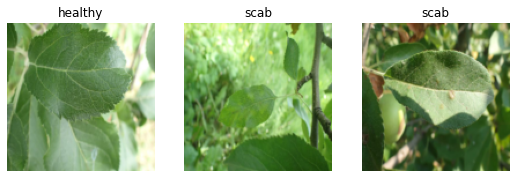

In [7]:
# show a set of images 
dls.show_batch(nrows=1, ncols=3)

In [ ]:
# model development
# pretrained model => RESNET50

# metric used= accuracy_multi

learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

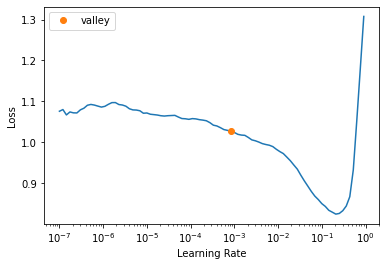

In [ ]:
# find learning rate

learn.lr_find()

In [ ]:
# fine-tuned model with a lr=10^-3 with 3 epochs to train and 4 epochs to freeze the pretrained layers

learn.fine_tune(3, base_lr=1e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.497131,0.371048,0.629182,03:03
1,0.360930,0.274981,0.824521,03:01
2,0.284257,0.243687,0.860664,03:01
3,0.236966,0.215112,0.883342,02:59


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.178768,0.168260,0.911254,03:08
1,0.103998,0.161935,0.924763,03:07
2,0.041363,0.165195,0.927312,03:12


In [ ]:
# collected predictions to check 
preds,targs = learn.get_preds()
     

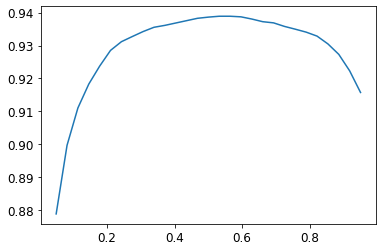

In [ ]:
# find best threshold value

xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
# find accuracy of the model
accuracy_multi(preds, targs, thresh=0.6, sigmoid=False)

TensorBase(0.9387)

In [ ]:
# save and export the model
learn.export('model_resnet.pkl')

In [8]:
# vgg16
learn_vgg = vision_learner(dls, vgg16_bn, metrics=partial(accuracy_multi, thresh=0.2))
learn_vgg.fine_tune(3, base_lr=1e-3, freeze_epochs=4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.827984,0.614118,0.343532,1:56:51
1,0.541845,0.370432,0.618089,02:57
2,0.321944,0.255065,0.846126,02:57
3,0.256094,0.220963,0.870370,02:58


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.178061,0.160502,0.915951,03:02
1,0.119510,0.144418,0.926955,03:04
2,0.068641,0.146945,0.930131,03:05


In [9]:
preds,targs = learn_vgg.get_preds()
     

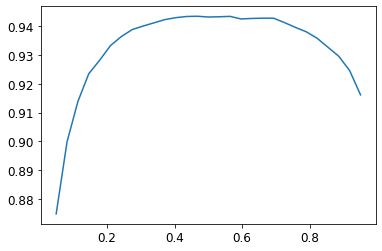

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
accuracy_multi(preds, targs, thresh=0.4, sigmoid=False)

TensorBase(0.9426)

In [10]:
learn_vgg.export('model_vgg.pkl')

In [ ]:
# cnn

In [11]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, dls.c)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
learn_cnn= Learner(dls, MyCNN(), metrics=partial(accuracy_multi, thresh=0.2))

# fine-tune the model
learn_cnn.fine_tune(5,1e-3)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.423394,0.408206,0.670737,02:45


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.402363,0.405426,0.691760,02:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.402363,0.405426,0.691760,02:38
1,0.400459,0.399788,0.699946,02:39
2,0.392364,0.392988,0.701914,02:32
3,0.386472,0.387946,0.685677,02:35
4,0.383731,0.386948,0.698649,02:37


In [ ]:
preds,targs = learn_cnn.get_preds()
     

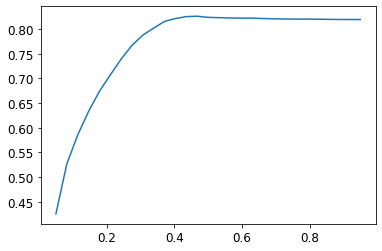

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
accuracy_multi(preds, targs, thresh=0.4, sigmoid=False)

TensorBase(0.8214)

In [13]:
learn_cnn.export('model_cnn.pkl')

In [ ]:
#efficient_net

In [ ]:
# create efficient net model

learn_eff = vision_learner(dls, efficientnet_b0, metrics=partial(accuracy_multi, thresh=0.2))
learn_eff.fine_tune(3, base_lr=1e-3, freeze_epochs=4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.877673,0.627919,0.349839,02:47


In [ ]:
preds,targs = learn_eff.get_preds()
     

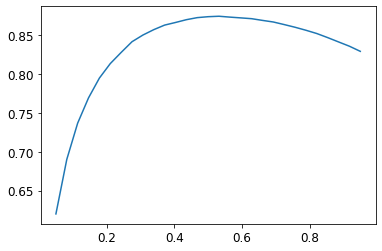

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
accuracy_multi(preds, targs, thresh=0.5, sigmoid=False)

TensorBase(0.8733)

In [ ]:
learn_eff.export('model_eff.pkl')